# DepMap Explorations & HRD Feature Engineering 🧬

**Objective**: Explore DepMap cell line data and systematically define homologous recombination deficiency (HRD) labels and genomic instability features. These engineered features will enable robust downstream analyses of PARP inhibitor sensitivity across diverse cancer models.


---
---
---

## 1. Setup 📦

---

In [260]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ptitprince as pt
import seaborn as sns

# Computational Modules
from scipy.stats import norm, zscore
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utils
from IPython.display import display, HTML, IFrame, Image
import os

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
pio.renderers.default = 'svg'
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load and organize DepMap cell line metadata, drug response data, and genomic features for downstream analysis.

---

In [69]:
# Define file path relative to the user OS
BASE_DIR = os.getcwd()
cell_line_models_path = os.path.join(BASE_DIR, 'data/raw_models.csv')
drug_response_path = os.path.join(BASE_DIR, 'data/raw_prism_drug_response.csv')
ccle_mutations_path = os.path.join(BASE_DIR, 'data/raw_CCLE_mutations.csv')
omics_signatures_path = os.path.join(BASE_DIR, 'data/raw_omics_global_signatures.csv')
damaging_mutations_path = os.path.join(BASE_DIR, 'data/raw_omics_somatic_mutations_matrix_damaging.csv')


# Load DepMap data into local dataframe (disable chunked dtype inference)
ccl_models_df = pd.read_csv(cell_line_models_path, low_memory=False)  # cancer cell line models
drug_response_df = pd.read_csv(drug_response_path, low_memory=False)  # prism secondary drug response
ccle_mutations_df = pd.read_csv(ccle_mutations_path, low_memory=False)  # ccle mutations
omics_signatures_df = pd.read_csv(omics_signatures_path, low_memory=False)  # genomic signatures
damaging_mutations_df = pd.read_csv(damaging_mutations_path, low_memory=False)  # damaging somatic mutation matrix

The original datasets were downloaded from DepMap’s public [portal](https://depmap.org/portal/data_page/?tab=allData).

- **`ccl_models_df`**: Contains metadata describing all cancer cell line models from the DepMap portal. 

- **`drug_response_df`**: Contains drug response measurements for multiple compounds, including dose–response metrics.

- **`ccle_mutations_df`**: Contains somatic point mutations and short insertions/deletions identified in DepMap cell lines based on CCLE sequencing data.

- **`omics_signatures_df`**: Contains genome-wide instability metrics derived from WES/WGS data, including loss of heterozygosity fraction (LoHFraction), chromosomal instability (CIN), whole-genome doubling (WGD), and aneuploidy scores. These features serve as continuous proxies for homologous recombination deficiency–associated genomic scarring.

- **`damaging_mutations_df`**: Contains a gene-level binary matrix indicating the presence of damaging somatic alterations in each cell line. A gene is considered damaged if it harbors at least one likely loss-of-function mutation, as defined by DepMap’s mutation annotation pipeline. This dataset is used to define BRCA-associated homologous recombination deficiency.

**Note:** Cell line metadata were obtained from DepMap release 25Q3. PRISM secondary drug response data (20Q2) and CCLE mutation annotations (22Q2) were obtained from earlier DepMap releases, as these datasets are not updated every quarter. All datasets are harmonized using stable DepMap ModelIDs. Furthermore, only PRISM secondary screen data is used for drug response analyses, as it provides more reliable dose–response metrics, whereas the primary screen is intended for broader, exploratory use.


## 3. Cohort Definition & Data Subsetting 🧩

**Objective**: Define the analysis cohort by selecting relevant PARP inhibitors and harmonize the drug response data with cancer cell line model metadata.

**Methodology**: First, the PRISM drug response dataset is filtered to retain measurements for a single PARP inhibitor. Second, the presence of multiple measurements per cell line is assessed, and replicates are collapsed by taking the median AUC for each cell line. Third, the summarized drug response data is joined to cancer cell line model metadata using shared DepMap identifiers. Finally, basic data validation is performed by inspecting summary statistics and missing values of the merged drug response values prior to further data engineering steps.


---

In [70]:
# Filter for specific PARPi of interest (Olaparib)
olaparib_df = drug_response_df[drug_response_df['name'] == 'olaparib'].copy()
olaparib_df.head()

,broad_id,depmap_id,ccle_name,screen_id,upper_limit,lower_limit,slope,r2,auc,ec50,ic50,passed_str_profiling,row_name,name,moa,target,disease.area,indication,smiles,phase
19950,BRD-K02113016-001-19-6,ACH-001001,143B_BONE,MTS010,1.065926,-12.073207,1.242774,0.854518,0.958427,100.376033,8.279681,True,PR300_ACH-001001,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched
19951,BRD-K02113016-001-19-6,ACH-000956,22RV1_PROSTATE,MTS010,4.202372,0.902855,5.805362,0.643954,0.907265,0.000436,NaN,True,PR500_ACH-000956,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched
19952,BRD-K02113016-001-19-6,ACH-000948,2313287_STOMACH,MTS010,15.926338,-14.072661,0.003058,0.750375,0.897542,0.021948,NaN,True,PR500_ACH-000948,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched
19953,BRD-K02113016-001-19-6,ACH-000011,253J_URINARY_TRACT,MTS010,1.160639,-9.992536,0.394690,0.792572,0.956256,22342.745544,NaN,True,PR500_ACH-000011,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched
19954,BRD-K02113016-001-19-6,ACH-000026,253JBV_URINARY_TRACT,MTS010,1.085837,-49.229494,0.855084,0.737689,0.971945,2388.209579,NaN,True,PR500_ACH-000026,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched


Since this study aims to systematically examine how multiple definitions of HRD relate to drug response, the initial phase will focus on a single drug to clearly interpret these relationships before expanding to a multi-drug analysis. **Olaparib** was chosen as the primary drug because it is widely studied and has strong clinical relevance.

In [71]:
# Count replicates (number of measurements per cell line)
replicate_counts = olaparib_df.groupby('depmap_id').size()
(replicate_counts > 1).sum()  

411

PRISM drug screens often include replicates (multiple rows per cell line and drug), arising from multiple wells per dose or even separate experimental runs altogether. Therefore, this must be accounted for before further explorations.

In [96]:
# Collapse replicates using median AUC per cell line
olaparib_df = olaparib_df.groupby('depmap_id', as_index=False).agg({'auc': 'median'})
olaparib_df.shape

(688, 2)

The median AUC was used to collapse replicates for each cell line. The median is robust to outliers and variability between experimental replicates, providing a representative measure of drug response while minimizing the influence of extreme values that may arise from technical or biological noise. `olaparib_db` contains 688 unique cell lines that was screened with olaparib, with each AUC measure.

In [148]:
# Join olaparib drug response with cell line metadata
olaparib_models_df = (
    ccl_models_df
    .merge(olaparib_df, left_on='ModelID', right_on='depmap_id', how='left')
    .drop(columns=['depmap_id'])  # Remove redundant column after merge
    .reset_index(drop=True)
)

# Filter out irrelevant cell models (no Olaparib screen = no AUC data)
olaparib_models_df = olaparib_models_df.dropna(subset=['auc']).copy() 

In [149]:
# Validate AUC values range
olaparib_models_df.auc.describe()

count    687.000000
mean       0.954075
std        0.137833
min        0.634467
25%        0.867769
50%        0.936337
75%        1.032681
max        1.856211
Name: auc, dtype: float64

In [150]:
# Validation check ensuring all olaparib data came through
print(len(olaparib_models_df))
print(len(olaparib_df))

687
688


In [151]:
# Check for missing cell line model in DepMap's Models.csv 
(olaparib_df
    .loc[~olaparib_df['depmap_id'].isin(ccl_models_df['ModelID']), 'depmap_id']
    .unique())

array(['ACH-000010'], dtype=object)

The cell line metadata from ccl_models_df was joined with the olaparib drug response data using unique cell line identifiers, resulting in a unified dataset that links molecular features with corresponding drug response metrics for each model. Cell line models that weren't treated with Olaparib were filtered out as this project focuses on models screened for Olaparib. 

Basic validation checks were performed to ensure the AUC values are within the appropriate range and to identify missing data. The final dataset contained one fewer cell line than the original Olaparib response dataset. This discrepancy suggests that one cell line present in the Olaparib dataset was not represented in the original `ccl_models_df`. Manual inspection of the source CSV files confirmed that the missing model corresponds to `ACH-000010`. This inconsistency likely reflects a coverage difference between DepMap data tables and could be something to flag for DepMap.

## 4. HRD Definition & Feature Engineering 🛠️

**Objective**: Define multiple biologically distinct homologous recombination deficiency (HRD) labels and scores to prepare dataset for studying how HRD status relates to PARP inhibitor response.

**Methodology**: First, damaging somatic mutations in BRCA1 and BRCA2 define a binary HRD label (HRD_BRCA). Second, genomic scar metrics (LOH, CIN, WGD, and aneuploidy) are extracted for all cell lines, and missing values are imputed using the median. Third, these features are standardized and combined into a composite genomic HRD score (HRD_genomic_score), which is converted to a binary label (HRD_genomic) using a Gaussian Mixture Model–derived threshold. Finally, BRCA-driven and genomic-scar-based HRD calls are integrated into a unified binary feature (HRD_positive) to capture all HRD-positive cell lines for downstream analysis.

---

### 4a. BRCA-based HRD (Mutation-defined)

**BRCA1** and **BRCA2** are core components of the **homologous recombination** (**HR**) DNA repair pathway, which repairs double-strand DNA breaks with high fidelity. Loss-of-function mutations in either gene impair HR activity, resulting in **homologous recombination deficiency** (**HRD**). Tumors with BRCA-associated HRD accumulate characteristic patterns of genomic instability and are particularly sensitive to PARP inhibition, making BRCA mutation status one of the most established clinical biomarkers of HRD.

In [105]:
# Examine mutation data
damaging_mutations_df.columns

Index(['Unnamed: 0', 'SequencingID', 'ModelID', 'ModelConditionID',
       'IsDefaultEntryForModel', 'IsDefaultEntryForMC', 'FAM87B (400728)',
       'LINC01128 (643837)', 'LINC02593 (100130417)', 'SAMD11 (148398)',
       ...
       'CTSLP8 (1518)', 'ANKRD19P (138649)', 'LINC00587 (414319)',
       'LINC02907 (157927)', 'SSX13P (326341)', 'SSX8P (280659)',
       'SOCS5P4 (100132415)', 'KIF4CP (347363)', 'GLRA4 (441509)',
       'TPTE2P4 (286573)'],
      dtype='object', length=19622)

In [65]:
# Search for BRCA-related features
brca_cols = [col for col in damaging_mutations_df.columns if 'brca' in col.lower()]
brca_cols

['BRCA2 (675)', 'BRCA1 (672)']

In [109]:
# Subset damaging mutation matrix to ModelID + BRCA genes
brca_mutations_df = damaging_mutations_df[['ModelID'] + brca_cols].copy()

# Define BRCA HRD status as HRD = damaging mutation in BRCA1 or BRCA2
brca_mutations_df['HRD_BRCA'] = (brca_mutations_df[brca_cols].sum(axis=1) > 0).astype(int)

# Keep only relevant columns moving forward
brca_mutations_df = brca_mutations_df[['ModelID', 'HRD_BRCA']]

brca_mutations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ModelID   3021 non-null   object
 1   HRD_BRCA  3021 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.3+ KB


BRCA-associated HRD was defined using damaging somatic mutations in BRCA1 or BRCA2. A cell line was labeled as HRD-positive (`HRD_BRCA = 1`) if it harbors at least one damaging mutation in either gene, and HRD-negative (`HRD_BRCA = 0`) otherwise. This binary variable represents a mutation-based proxy for HRD and will serve as one of the two complementary HRD definitions used in this project. 

`brca_mutations_df` will need to be further filtered to only include records of cell line models that exist within the `olaparib_models_df`, as per this study. But this will be conducted later in order to keep this pharmacological data layer in tact in case for separate explorations or extended drug studies in the future. 

### 4b. Genomic Scar–based HRD (LOH / CIN / WGD / Aneuploidy)

Not all HRD is driven by BRCA1/2 mutations. Defects in other components of the homologous recombination pathway can similarly compromise DNA repair, leading to characteristic patterns of chromosomal instability (i.e., **genomic scars**). Although canonical genomic scar scores are not available via DepMap, related metrics such as **loss of heterozygosity** (**LOH**), **chromosomal instability** (**CIN**), **whole-genome doubling** (**WGD**), and **aneuploidy** capture these patterns. These features were already extracted from the Omics Global Signatures dataset, and therefore will serve as proxies to detect HRD in BRCA wild-type cell lines.

In this section, these metrics will be integrated into a composite score to define a binary HRD label (`HRD_genomic`), in order to identify cell lines that lack BRCA mutations but still exhibit HRD-like genomic instability patterns.


In [153]:
# Subset relevant genomic scar metrics
scar_metrics = ['LoHFraction', 'CIN', 'WGD', 'Aneuploidy']
genomic_scar_df = omics_signatures_df[['ModelID'] + scar_metrics].copy()

genomic_scar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ModelID      3021 non-null   object 
 1   LoHFraction  2582 non-null   float64
 2   CIN          2582 non-null   float64
 3   WGD          2582 non-null   float64
 4   Aneuploidy   2582 non-null   float64
dtypes: float64(4), object(1)
memory usage: 118.1+ KB


The four relevant scar metrics were extracted above for each cell line. However, only 2582 of the 3021 models (~14%) contained complete information. The remaining missing records must be addressed before standardizing these features to create a composite HRD score. Following the framework outlined by *[Little & Rubin (1987)](https://stefvanbuuren.name/fimd/sec-MCAR.html)*, the mechanism of missingness was assessed. Since the same cell line models are missing values across all four metrics, the data is most consistent with a *Missing at Random (MAR)* scenario due to assay availability. Therefore, imputation is required to mitigate any potential bias.

A deeper look into the distributions of these features will be useful to determine the proper steps for imputing missing data and creating a composite score. 

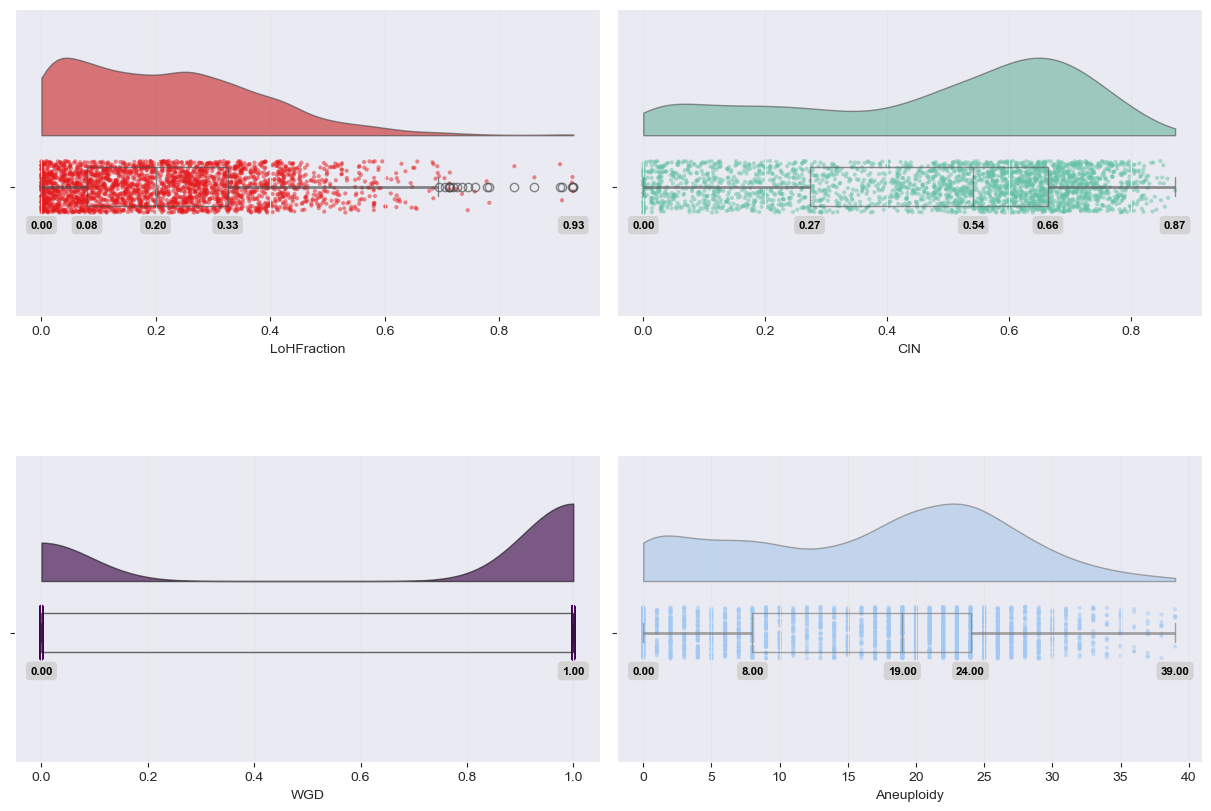

In [142]:
# Set up figure & individual subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = ['Set1', 'Set2', 'viridis', 'pastel']

# Plot raincloud for each metric
for i, metric in enumerate(scar_metrics):
    cloud = pt.RainCloud(
        data=genomic_scar_df,
        y=metric,
        bw=0.2,
        alpha=0.65,
        rain_alpha=0.5,
        width_viol=0.6,
        orient='h',
        palette=rc_palettes[i],
        hue=i,
        ax=axs[i],
    )
    
    # Label quartiles
    desc_stats = genomic_scar_df[[metric]].quantile(q=[0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats[metric]:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )


**Observations:**

`LoHFraction`

- Right-skewed distribution with most observations concentrated at low values 
- Small sample of outliers with high loss of heterozygosity (up to ~0.93)
- Median: 0.20, IQR: 0.08 - 0.33

`CIN`

- Broadly distributed with an overall left skew (peak near the 75th percentile)
- Values mostly concentrated in two areas: above the median and below the 25th percentile
- More variability compared to LoHFraction, but fewer extreme outliers indicating substantial chromosomal instability across many samples, rather than being confined to a small subset
- Median: 0.54, IQR: 0.27 - 0.66

`WGD`

- Binary (0 or 1) distribution, representing the presense / absence of whole-genome duplication
- Most samples show WGD, with only a smaller subset at the 0 mark (Median: 1)

`Aneuploidy`

- Discrete, integer-valued distribution reflecting whole chromosome or chromosome-arm alterations
- Broadly distributed with an asymmetric shape, peaking between the median and 75th percentile
- Declines sharply toward higher values, with a broader shoulder toward lower aneuploidy 
- Median: 19, IQR: 8 - 24

Overall, these genomic instability metrics exhibit markedly different distributions. Loss of heterozygosity is generally low, with rare extreme values, while CIN and Aneuploidy show broader, more continuous variation across samples. These patterns suggest that genomic instability arises through multiple, partially independent mechanisms, with different samples showing distinct dominant instability patterns.

Given these distributional characteristics, missing data should be imputed using the median to mitigate the influence of skew and outliers. Additionally, when combining these metrics into a composite score, standardization (via scaling techniques) is essential to account for their differing distributions and ranges.

In [162]:
# Impute missing values with median for each scar metric
genomic_scar_df[scar_metrics] = genomic_scar_df[scar_metrics].fillna(
    genomic_scar_df[scar_metrics].median())

In [169]:
# Fit and transform the four scar metrics
scaler = StandardScaler()
scaled_values = scaler.fit_transform(genomic_scar_df[scar_metrics].copy())

# Create new scaled columns
scaled_col_names = [f'z_{col}' for col in scar_metrics]
scaled_genomic_scar_df = genomic_scar_df.copy()
scaled_genomic_scar_df[scaled_col_names] = scaled_values

scaled_genomic_scar_df.head()

,ModelID,LoHFraction,CIN,WGD,Aneuploidy,z_LoHFraction,z_CIN,z_WGD,z_Aneuploidy
0,ACH-000839,0.107443,0.502634,1.0,20.0,-0.716062,0.091463,0.628793,0.324333
1,ACH-000041,0.130089,0.523865,1.0,19.0,-0.566444,0.187333,0.628793,0.213832
2,ACH-002046,0.222342,0.679772,1.0,30.0,0.043062,0.891328,0.628793,1.429342
3,ACH-002048,0.199456,0.540837,1.0,19.0,-0.108144,0.263968,0.628793,0.213832
4,ACH-000042,0.199456,0.540837,1.0,19.0,-0.108144,0.263968,0.628793,0.213832


The genomic scar metrics span different numerical ranges and distributional shapes, so they must be placed on a common scale before being combined into a composite metric. Each feature was therefore standardized using z-score normalization, allowing values to represent how extreme a cell line is relative to the overall population. This approach prevents any single metric from dominating the composite score solely due of its magnitude, while still preserving biologically meaningful variation across samples.

Alternative approaches, such as robust scaling, were considered here due to the presence of extreme outliers in some metrics. However, because the primary goal is to capture relative deviation from the cohort mean rather than attentuate extremes, z-scoring was deemed more appropriate. Although robust scalers reduce the influence of outliers and are useful for noise control, the high values observed here likely represent true biological signals associated with HRD. Moreover, the large sample size, combined with prior median-based imputation, further mitigates outlier influence already, further strengthening the case for a standard scalar. 

Standardization centers each genomic scar metric at the cohort mean and expresses values in units of standard deviation. Under this transformation, a value of zero represents the average level of genomic instability, positive values indicate above-average scar burden, and negative values indicate below-average burden.

This transformation enables direct comparison and aggregation across variables that originally differed in scale, range, and distribution. For the binary WGD column, z-score normalization simply maps absence to below-average instability and presence to above-average instability, preserving its biological interpretation while allowing it to contribute proportionally to the composite score.

With all four genomic scar metrics placed on a common scale, they can now be integrated into a single composite feature representing genomic scar–based HRD.

In [174]:
# Compute composite HRD score using mean of the scaled data
scaled_genomic_scar_df['HRD_genomic_score'] = scaled_genomic_scar_df[scaled_col_names].mean(axis=1)

scaled_genomic_scar_df[['ModelID', 'HRD_genomic_score']].head()

,ModelID,HRD_genomic_score
0,ACH-000839,0.082132
1,ACH-000041,0.115879
2,ACH-002046,0.748131
3,ACH-002048,0.249613
4,ACH-000042,0.249613


The standardized genomic scar metrics were averaged to generate a continuous composite HRD score. Because each feature is expressed in units of standard deviation, this approach ensures equal contribution from all metrics without allowing any single feature to dominate due to scale differences. Higher values correspond to greater overall genomic instability consistent with homologous recombination deficiency.

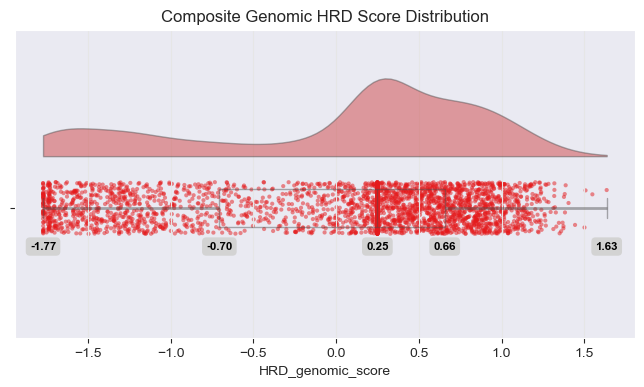

In [185]:
# Set up figure for composite score
plt.figure(figsize=(8, 4))

# Plot raincloud for composite metric
composite_cloud = pt.RainCloud(
    data=scaled_genomic_scar_df,
    y='HRD_genomic_score',
    bw=0.2,
    alpha=0.45,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette='Set1',
    hue=0,
)

# Label quartiles
composite_desc_stats = scaled_genomic_scar_df[['HRD_genomic_score']].quantile(q=[0, 0.25, 0.5, 0.75, 1])
for stat in composite_desc_stats['HRD_genomic_score']:
    composite_cloud.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )

plt.title('Composite Genomic HRD Score Distribution')
plt.show()

The feature-engineered composite genomic HRD score ranges from −1.77 to 1.63, demonstrating substantial variability across cell lines. The distribution is fairly unimodal and centered slightly above the median (0.25), with most models occupied densely above that range. Negative scores indicate genomic instability levels below the cohort mean, while positive scores reflect above-average burden relative to other models. No extreme or isolated artifacts are evident, suggesting the aggregation and scaling steps produced a stable continuous measure suitable for downstream threshold-based classification. The next step involves figuring out this exact threshold.

In [188]:
# Fit 2-Component GMM on HRD scores
hrd_genomic_scores = scaled_genomic_scar_df['HRD_genomic_score'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(hrd_genomic_scores)

# Get means and covariances of the two Gaussians
gmm_means = gmm.means_.flatten()
gmm_covs = gmm.covariances_.flatten()
mu1, mu2 = gmm_means
sigma1, sigma2 = np.sqrt(gmm_covs)

In [189]:
### Compute the intersection point of the two Gaussians (Solve: N1(x) = N2(x) for x)

# Quadratic coefficients for solving intersection
a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
b = mu2/(sigma2**2) - mu1/(sigma1**2)
c = (mu1**2)/(2*sigma1**2) - (mu2**2)/(2*sigma2**2) - np.log(sigma2/sigma1)

# Solve for x (intersection point)
threshold_candidates = np.roots([a, b, c])

# Pick the value within the range of observed scores
threshold = threshold_candidates[(threshold_candidates > hrd_genomic_scores.min()) & (threshold_candidates < hrd_genomic_scores.max())][0]
print(f'GMM-derived HRD threshold: {threshold:.3f}')

# Create binary HRD label
scaled_genomic_scar_df['HRD_genomic'] = (scaled_genomic_scar_df['HRD_genomic_score'] >= threshold).astype(int)

GMM-derived HRD threshold: -0.406


In [190]:
# Validate the engineered threshold by checking overlap with BRCA-positive cell lines
brca_overlap = brca_mutations_df.merge(
    scaled_genomic_scar_df[['ModelID', 'HRD_genomic']], on='ModelID'
)
brca_positive_rate = brca_overlap[brca_overlap['HRD_BRCA'] == 1]['HRD_genomic'].mean()
print(f'Fraction of BRCA-mutant lines captured as HRD-positive: {brca_positive_rate:.2%}')

Fraction of BRCA-mutant lines captured as HRD-positive: 73.53%


To convert the continuous composite genomic HRD score into a binary label, a two-component Gaussian Mixture Model (GMM) was fitted to the score distribution. This approach assumes that cell lines comprise two overlapping subpopulations corresponding to HRD-negative (lower genomic instability) and HRD-positive (higher genomic instability) states.

The intersection point of the two Gaussian components was computed analytically and used as the classification threshold, providing an objective, data-driven cutoff rather than relying on an arbitrary percentile-based rule. Using this approach, a threshold of −0.406 was identified and applied to define the binary genomic scar–based HRD label (HRD_genomic). This threshold lies within the dense region of the score distribution and does not rely on extreme values, indicating a stable and robust separation between subpopulations.

To assess biological validity, the resulting classification was compared against BRCA1/2 mutation status. The majority of BRCA-mutant cell lines were classified as HRD-positive under this threshold, confirming that the genomic scar–based definition captures canonical HRD cases while also identifying BRCA wild-type models with HRD-like genomic instability. Together, these results support both the statistical validity and biological relevance of the engineered HRD_genomic label.

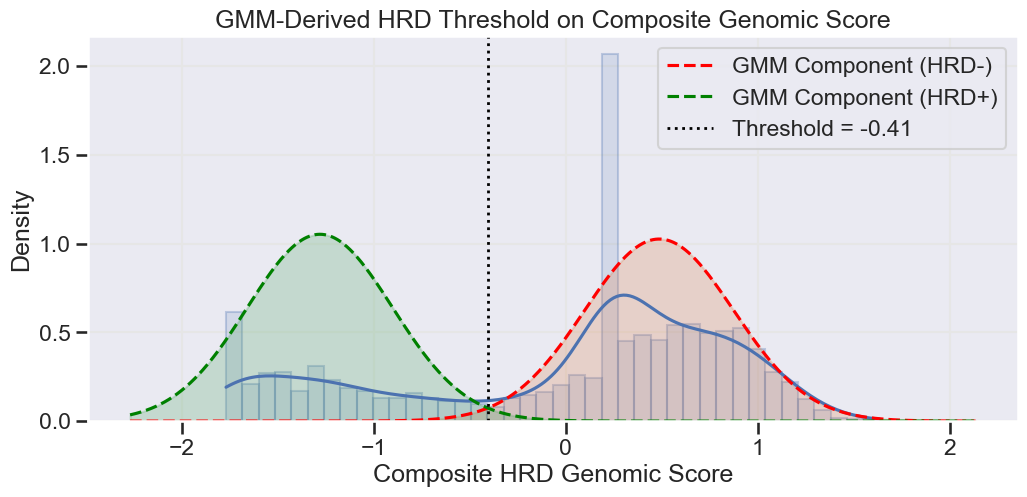

In [251]:
# Set up figure
plt.figure(figsize=(12, 5))

# Plot the histogram + KDE of HRD scores
sns.histplot(
    scaled_genomic_scar_df['HRD_genomic_score'], 
    bins=40, 
    kde=True, 
    color='#4C72B0', 
    stat='density', 
    alpha=0.15, 
    edgecolor=(0.298, 0.447, 0.69, 0.30)  # in RGB format to accomodate edge alpha
)

# Plot the two GMM components 
x_vals = np.linspace(hrd_genomic_scores.min()-0.5, hrd_genomic_scores.max()+0.5, 1000)
pdf1 = norm.pdf(x_vals, loc=mu1, scale=sigma1)
pdf2 = norm.pdf(x_vals, loc=mu2, scale=sigma2)
plt.plot(x_vals, pdf1, color='red', linestyle='--', label='GMM Component (HRD-)')
plt.plot(x_vals, pdf2, color='green', linestyle='--', label='GMM Component (HRD+)')
plt.fill_between(x_vals, pdf1, color='#DD8452', alpha=0.25)
plt.fill_between(x_vals, pdf2, color='#55A868', alpha=0.25)

# Plot the threshold
plt.axvline(threshold, color='black', linestyle='dotted', linewidth=2, label=f'Threshold = {threshold:.2f}')

# Output labels and legend
plt.title('GMM-Derived HRD Threshold on Composite Genomic Score')
plt.xlabel('Composite HRD Genomic Score')
plt.ylabel('Density')
plt.legend()
plt.show()

The histogram and KDE (in blue) show the distribution of composite genomic HRD scores across cell lines. The red and green dashed lines correspond to the two Gaussian components fitted by the GMM, representing the inferred HRD-negative and HRD-positive subpopulations. The black dotted line indicates the analytically derived threshold used to convert the continuous HRD score into the binary `HRD_genomic` label.

This visualization demonstrates how the data-driven threshold effectively separates cell lines with low versus high genomic instability while reflecting the natural structure of the score distribution. It also provides a visual validation that the threshold is reasonable and aligns with the density of the observed scores.

### 4c. Combined HRD Definition (BRCA + Genomic Scar Composite Score)

Initially, this project aimed to define HRD using three complementary approaches: (1) BRCA1/2 damaging mutations, (2) canonical genomic scar scores (LOH, LST, TAI), and (3) a composite score combining multiple instability proxies. Because canonical genomic scar scores are unavailable in DepMap, this analysis was adapted to combine BRCA-driven HRD and a data-driven genomic scar composite into a single unified HRD label. In this section, this combined feature will be constructed to prepare for the main analysis.

In [253]:
# Merge BRCA and genomic HRD labels
hrd_combined_df = brca_mutations_df[['ModelID', 'HRD_BRCA']].merge(
    scaled_genomic_scar_df[['ModelID', 'HRD_genomic']], 
    on='ModelID',
    how='outer'  # keep all cell lines with either info
)
hrd_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5417 entries, 0 to 5416
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ModelID      5417 non-null   object
 1   HRD_BRCA     5417 non-null   int64 
 2   HRD_genomic  5417 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 127.1+ KB


In [258]:
# Define unified HRD feature
hrd_combined_df['HRD_positive'] = ((hrd_combined_df['HRD_BRCA'] == 1) | 
                                   (hrd_combined_df['HRD_genomic'] == 1)).astype(int)

In [261]:
# Examine summary statistics
total_lines = hrd_combined_df.shape[0]
hrd_brca_count = hrd_combined_df['HRD_BRCA'].sum()
hrd_genomic_count = hrd_combined_df['HRD_genomic'].sum()
hrd_total_count = hrd_combined_df['HRD_positive'].sum()

print(f'Total cell lines: {total_lines}')
print(f'BRCA-mutant HRD: {hrd_brca_count} ({hrd_brca_count/total_lines:.1%})')
print(f'Genomic HRD: {hrd_genomic_count} ({hrd_genomic_count/total_lines:.1%})')
print(f'Unified HRD-positive: {hrd_total_count} ({hrd_total_count/total_lines:.1%})')

Total cell lines: 5417
BRCA-mutant HRD: 272 (5.0%)
Genomic HRD: 3965 (73.2%)
Unified HRD-positive: 4037 (74.5%)


The BRCA mutation and GMM-derived genomic HRD labels were merged, preserving all cell lines with either type of information. A binary `HRD_positive` feature was created, flagging a cell line as HRD+ if it was positive by either BRCA mutation or genomic instability.

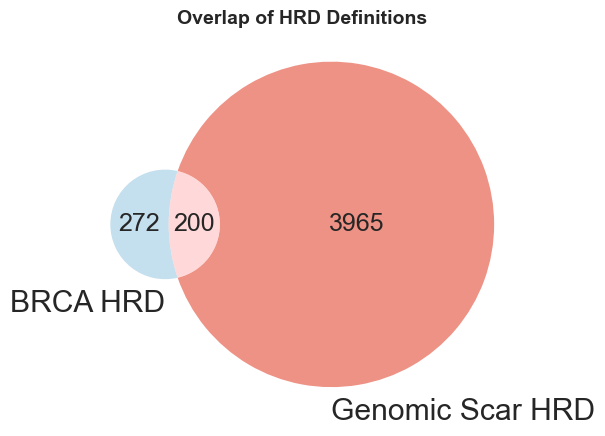

In [269]:
# Visualize overlap between both HRD definitions
plt.figure(figsize=(6,5))
venn2(
    subsets=(hrd_brca_count, hrd_genomic_count, 
             (hrd_combined_df['HRD_BRCA'] & hrd_combined_df['HRD_genomic']).sum()),
    set_labels=('BRCA HRD', 'Genomic Scar HRD'),
    set_colors=('#9ECAE1', '#E24A33'),
    alpha=0.6
)
plt.title('Overlap of HRD Definitions', fontsize=14, weight='bold')
plt.show()

The Venn diagram illustrates the overlap between BRCA-driven and genomic scar-driven HRD definitions. A small subset of cell lines is captured by both criteria, while others are uniquely positive for either BRCA mutations or genomic instability. The unified `HRD_positive` label captures nearly all cell lines flagged by either definition, integrating canonical BRCA-driven deficiency with broader genomic instability. This ensures downstream analyses account for multiple mechanisms of homologous recombination deficiency while maintaining a single interpretable feature.

## 5. Dataset Integration & Export 💾 

**Objective**: Merge all relevant datasets (PARP inhibitor response, BRCA mutation status, and genomic HRD features) into a single, harmonized dataframe and export as pickled files for downstream analysis of HRD associations with drug sensitivity.

---

In [290]:
# Merge olaparib drug response with BRCA and genomic HRD labels
ccl_hrd_olaparib_df = olaparib_models_df.merge(
    brca_mutations_df[['ModelID', 'HRD_BRCA']], on='ModelID', how='left').merge(
    scaled_genomic_scar_df[['ModelID', 'HRD_genomic_score', 'HRD_genomic']], 
    on='ModelID', 
    how='left'
)
ccl_hrd_olaparib_df.head(5)

,ModelID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,RRID,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,SampleCollectionSite,SourceType,SourceDetail,CatalogNumber,ModelType,TissueOrigin,ModelDerivationMaterial,ModelTreatment,PatientTreatmentStatus,PatientTreatmentType,PatientTreatmentDetails,Stage,StagingSystem,PatientTumorGrade,PatientTreatmentResponse,GrowthPattern,OnboardedMedia,FormulationID,SerumFreeMedia,PlateCoating,EngineeredModel,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,PediatricModelType,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID,ModelIDAlias,auc,HRD_BRCA,HRD_genomic_score,HRD_genomic
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.916763,0.0,0.440492,1.0
1,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.916763,0.0,0.254129,1.0
2,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.916763,0.0,0.440492,1.0
3,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.916763,0.0,0.254129,1.0
4,ACH-000004,PT-q4K2cp,HEL,HEL,AMLNOS,Myeloid,Acute Myeloid Leukemia,"AML, NOS",AMLNOS,JAK2 and TP53 mutations,CVCL_0001,30.0,Adult,Male,caucasian,Primary,haematopoietic_and_lymphoid_tissue,DSMZ,NaN,ACC 11,Cell Line,NaN,NaN,NaN,Post-treatment,NaN,NaN,NaN,NaN,NaN,NaN,Suspension,MF-001-001,RPMI + 10% FBS,False,NaN,NaN,NaN,NaN,NaN,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,True,Approved for public sharing - CCLE,JAK2 and TP53,783.0,SIDM00594,907053.0,NaN,0.986635,0.0,0.461712,1.0


In [288]:
# Merge all wrangled features (BRCA, genomic scar, omics, original ccl metadata, etc.)
comprehensive_df = olaparib_models_df.merge(
    ccl_models_df, on='ModelID', how='left', suffixes=('', '_ccl')).merge(
    brca_mutations_df[['ModelID', 'HRD_BRCA']], on='ModelID', how='left').merge(
    scaled_genomic_scar_df, 
    on='ModelID', 
    how='left', 
    suffixes=('', '_scar')
)
comprehensive_df.head(5)

,ModelID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,RRID,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,SampleCollectionSite,SourceType,SourceDetail,CatalogNumber,ModelType,TissueOrigin,ModelDerivationMaterial,ModelTreatment,PatientTreatmentStatus,PatientTreatmentType,PatientTreatmentDetails,Stage,StagingSystem,PatientTumorGrade,PatientTreatmentResponse,GrowthPattern,OnboardedMedia,FormulationID,SerumFreeMedia,PlateCoating,EngineeredModel,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,PediatricModelType,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID,ModelIDAlias,auc,PatientID_ccl,CellLineName_ccl,StrippedCellLineName_ccl,DepmapModelType_ccl,OncotreeLineage_ccl,OncotreePrimaryDisease_ccl,OncotreeSubtype_ccl,OncotreeCode_ccl,PatientSubtypeFeatures_ccl,RRID_ccl,Age_ccl,AgeCategory_ccl,Sex_ccl,PatientRace_ccl,PrimaryOrMetastasis_ccl,SampleCollectionSite_ccl,SourceType_ccl,SourceDetail_ccl,CatalogNumber_ccl,ModelType_ccl,TissueOrigin_ccl,ModelDerivationMaterial_ccl,ModelTreatment_ccl,PatientTreatmentStatus_ccl,PatientTreatmentType_ccl,PatientTreatmentDetails_ccl,Stage_ccl,StagingSystem_ccl,PatientTumorGrade_ccl,PatientTreatmentResponse_ccl,GrowthPattern_ccl,OnboardedMedia_ccl,FormulationID_ccl,SerumFreeMedia_ccl,PlateCoating_ccl,EngineeredModel_ccl,EngineeredModelDetails_ccl,CulturedResistanceDrug_ccl,PublicComments_ccl,CCLEName_ccl,HCMIID_ccl,PediatricModelType_ccl,ModelAvailableInDbgap_ccl,ModelSubtypeFeatures_ccl,WTSIMasterCellID_ccl,SangerModelID_ccl,COSMICID_ccl,ModelIDAlias_ccl,HRD_BRCA,LoHFraction,CIN,WGD,Aneuploidy,z_LoHFraction,z_CIN,z_WGD,z_Aneuploidy,HRD_genomic_score,HRD_genomic
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.916763,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.0,0.173789,0.649594,1.0,23.0,-0.277718,0.755059,0.628793,0.655836,0.440492,1.0
1,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.916763,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN,0.0,0.246913,0.524343,1.0,17.0,0.205404,0.189488,0.628793,-0.007169,0.254129,1.0
2,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% 

In [289]:
# Export analysis-ready datasets
ccl_hrd_olaparib_df.to_pickle(os.path.join(BASE_DIR, 'data/ccl_hrd_olaparib_df.pkl'))
comprehensive_df.to_pickle(os.path.join(BASE_DIR, 'data/comprehensive_df.pkl'))